# Impact Indicators: the probability of Fire in natural vegetation Land Use Land Cover (LULC) classes

Production date: 25-11-2024

Produced by: Luís Figueiredo and Rita Cunha (CoLAB +ATLANTIC)

## 🌍 Use case: Assessment of fire occurrence in natural vegetation LULC classes

## ❓ Quality assessment question
* **User Question: How well can satellite data show a major forestry wildfire event?**

In this Use Case, we will access the Fire burned area from 2001 to present derived from satellite observations (henceforth, FIRE) from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S). 
The pixel-level product of this dataset, including information on confidence levels, pixel detection flags, and land cover of burned pixels, will be used to quantify burned areas and associated land cover changes across European NUTS2 regions in Portugal.
The analysis will focus on the period 2016–2019, with particular attention to the catastrophic wildfire event on June 17, 2017, in Pedrógão Grande. This event, one of Portugal's most devastating wildfires, resulted in significant loss of life and environmental damage. By leveraging the detailed data provided in the BA dataset, we aim to calculate the spatial extent of burned areas and estimate the loss of tree-covered areas within affected regions.
This Use Case demonstrates the application of C3S datasets for high-resolution wildfire impact assessments, supporting disaster management, and landscape recovery planning, and serves as a regional example in alignment with the European State of Climate report [[1]](https://climate.copernicus.eu/esotc/2023).

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
- The FIRE dataset, when using LULC forest class, offers a consistent, high-resolution framework for tracking and measuring burned areas. This facilitates assessments of the effects of wildfires throughout Europe and allows for in-depth analysis of forest alterations that are in line with IPCC forest group definitions.

- The FIRE dataset plays a crucial role in determining burned areas, forest losses, and tree-cover reductions per geographical unit (e.g., NUTS2 regions) during catastrophic events such as the Pedrógão Grande wildfire (June 17, 2017).  Its pixel-level granularity ensures accurate spatial estimates of tree-cover reductions, supported by the confidence level information that highlights the reliability of detected burned areas. These capabilities align with its proven efficacy in studies conducted over wildfire-prone regions [[2]](https://www.mdpi.com/2073-4433/12/1/85).

- FIRE dataset has also been validated as a trustworthy tool for analyzing wildfire dynamics and post-fire vegetation recovery. For example, it has been effectively used to map burned areas and explore relationships between fire patterns and climatic drivers, such as drought and heatwaves ([[3]](https://www.mdpi.com/2571-6255/7/3/90) and [[4]](https://www.mdpi.com/2571-6255/3/4/57)).

- The FIRE dataset ([[5]](https://doi.org/10.1016/j.agrformet.2024.110108)) supports advanced analyses of wildfire impacts, by leveraging detailed pixel-level information, enhancing the understanding of spatial fire dynamics, and providing valuable data for risk management, mitigation planning, and long-term landscape recovery efforts.
```

```{figure} attachment:89bbb524-1d3b-42bd-9f7e-5ddf86780b04.png
---
---
```
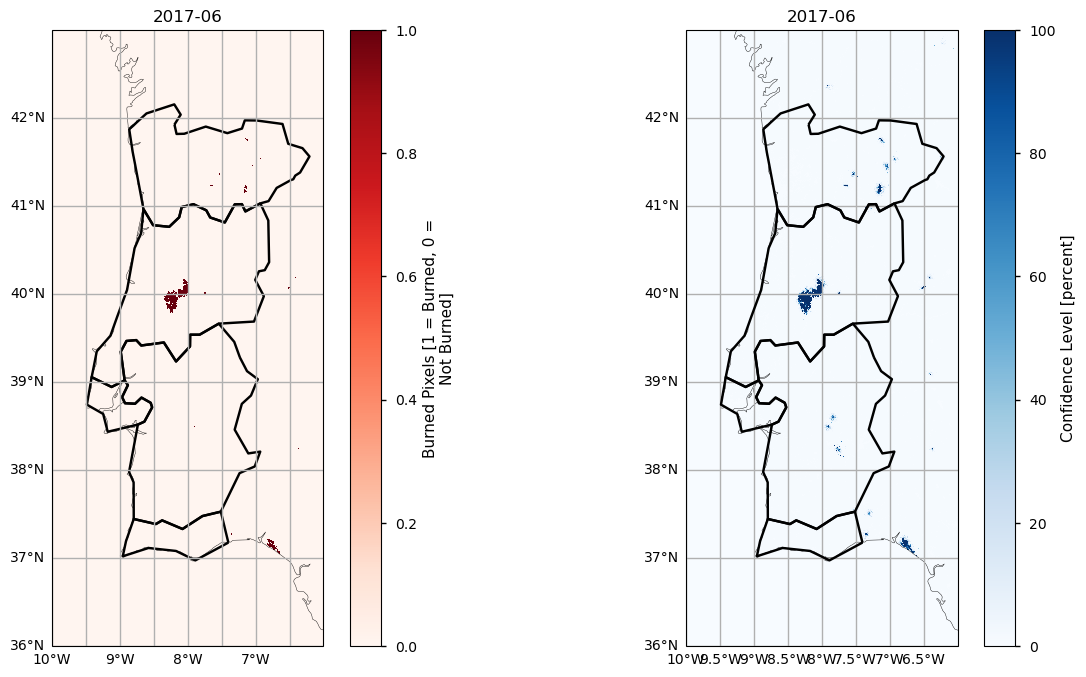

## 📋 Methodology

**[](code-section-1)**   
**[](code-section-2)**   
**[](code-section-3)**   
**[](code-section-4)**  
**[](code-section-5)**  

## 📈 Analysis and results

(code-section-1)=
### 1. Data Overview, download and NUTS regions definition

#### Import all the libraries/packages

We will be working with data in NetCDF format. To best handle this data we will use libraries for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.

In [1]:
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regionmask
import xarray as xr
from c3s_eqc_automatic_quality_control import download, plot, utils

plt.style.use("seaborn-v0_8-notebook")

#### Data overview

To search for data, visit the CDS website: http://cds.climate.copernicus.eu. Here you can search for 'Satellite observations' data using the search bar. The data we need for this tutorial is the Fire burned area from 2001 to present derived from satellite observations. This data provides global (at grid scale) and continents (at pixel scale) information of total burned area (BA), following the Global Climate Observing System (GCOS) convention. The dataset is provided with a high spatial resolution, through the analysis of reflectance changes from medium resolution sensors (Terra MODIS, Sentinel-3 OLCI) supported by thermal information.

The BA is identified by the date of the first detection of the burned signal in the case of the pixel product, and by the total BA per grid cell in the case of the grid product. Information such as land cover class, confidence level or standard error are also provided.

The BA products can be on pixel scale and grid scale, based on resolution and coverage. At the grid scale, data is provided globally with a horizontal resolution of 0.25° latitude by 0.25° longitude, offering a coarser spatial resolution that is suitable for broad, global analyses. 

This grid product data is available every 15 days in version 5.0cds and monthly in versions 5.1.1cds and 1.1. 

Conversely, at the pixel scale, data is more detailed, covering continents with a finer horizontal resolution of 250m or 300m, and is aggregated on a monthly basis. This pixel product provides higher spatial resolution suitable for more localized, detailed studies.

Different versions are available, offering the first global BA time series at 250 m resolution (FireCCI v5.0cds and FireCCI v5.1cds developed as part of the Fire ECV Climate Change Initiative Project (Fire CCI)). This algorithm was adapted to Sentinel-3 OLCI data to create the C3S v1.0 burned area product, extending the BA database to the present.

Having selected the correct dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. In this Use case, we will retrieve information of the Pixel ESA-CCI version. Considering this specific Use Case, we eill also, only download the data from 2016 to 2019 for only the month 6 (june). These can all be selected in the `Download data` tab from the CDS. In this tab a form appears in which we will select the following parameters to download, for example:

- Origin: ESA-CCI
- Sensor: MODIS
- Variable: Pixel
- Version: 5.1.1cds
- Region: europe
- Year: 2016 to 2019
- Month: 06
- Nominal day: 01
- Format: Zip file (.zip)

At the end of the download form, select `Show API request`. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook-

Having copied the API request to a Jupyter Notebook cell, running it will retrieve and download the data you requested into your local directory. However, before you run it, the terms and conditions of this particular dataset need to have been accepted directly at the CDS website. The option to view and accept these conditions is given at the end of the download form, just above the `Show API request` option. In addition, it is also useful to define the time period and AoI parameters and edit the request accordingly, as exemplified in the cells below.

### Download Fire Pixel and NUTS regions

In [2]:
# Region of interest
lon_slice = slice(-10, -6)
lat_slice = slice(43, 36)

# Shapefile with regions
shapefile_url = "https://gisco-services.ec.europa.eu/distribution/v2/nuts/shp/NUTS_RG_20M_2021_4326.shp.zip"

# Define forest codes
forest_codes = [50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90, 100, 160, 170]

In [3]:
# Define request
request = (
    "satellite-fire-burned-area",
    {
        "format": "zip",
        "origin": "esa_cci",
        "sensor": "modis",
        "version": "5_1_1cds",
        "region": "europe",
        "year": ["2016", "2017", "2018", "2019"],
        "variable": "pixel_variables",
        "month": "06",
        "nominal_day": "01",
    },
)

In [4]:
# Download and regionalize
ds = download.download_and_transform(
    *request,
    transform_func=utils.regionalise,
    transform_func_kwargs={"lon_slice": lon_slice, "lat_slice": lat_slice},
    chunks={"year": 1},
)
ds = ds.rio.write_crs(4326)
ds["time"] = (ds["time"] + pd.Timedelta("1D")).dt.strftime("%Y-%m")

100%|██████████| 4/4 [00:00<00:00, 11.49it/s]


(code-section-2)=
### 2. Total Burned Area Analysis

Quantify the Total Burned Area per NUTS region

In [6]:
scaling_factor = 0.002778
resolution_km = scaling_factor * 111.195
indexes = xr.DataArray(range(ds.sizes["latitude"]), dims="latitude")
lats = ds["latitude"].max() - indexes * scaling_factor
grid_cell_area = resolution_km**2 * np.cos(np.radians(lats))
grid_cell_area.attrs = {
    "standard_name": "cell_area",
    "long_name": "Area",
    "units": "km2",
}
ds = ds.assign_coords(cell_area=grid_cell_area)

In [7]:
gdf = gpd.read_file(shapefile_url)
gdf = gdf[(gdf["CNTR_CODE"] == "PT") & (gdf["LEVL_CODE"] == 2)]
gdf = gdf[:-2]
gdf = gdf.to_crs(epsg=4326)

regions = regionmask.from_geopandas(gdf, names="NUTS_NAME")
mask = regions.mask_3D(ds)
ds_region = ds.where(mask)
ds_region = (
    ds_region.assign_coords(region=ds_region["names"])
    .drop_vars("names")
    .sortby("region")
)

In [8]:
burned_pixels = (
    ds_region["cell_area"].where(ds_region["JD"] > 0).sum(["latitude", "longitude"])
)
burned_pixels.to_pandas()

region,Alentejo,Algarve,Centro (PT),Norte,Área Metropolitana de Lisboa
time,,,,,
2016-06,0.000000,0.0,0.000000,0.288531,0.0
2017-06,5.473672,0.0,743.152782,60.945786,0.0
2018-06,0.000000,0.0,0.000000,0.643154,0.0
2019-06,0.000000,0.0,1.987535,0.000000,0.0


This pivot table analysis aims to quantify and understand the spatial extent and impact of burned areas. Regions with zero values contribute no information about wildfire activity and are therefore excluded to streamline the focus on affected areas.

With that in mind, on the next analysis of this notebook, will be assessed only the NUTS regions of Alentejo, Centro (PT) and Norte.

(code-section-3)=
### 3. Maps of Burned Area and Confidence Levels 

This analysis is performed for each Timestamp of the dataset, considering only the Portugal NUTS region


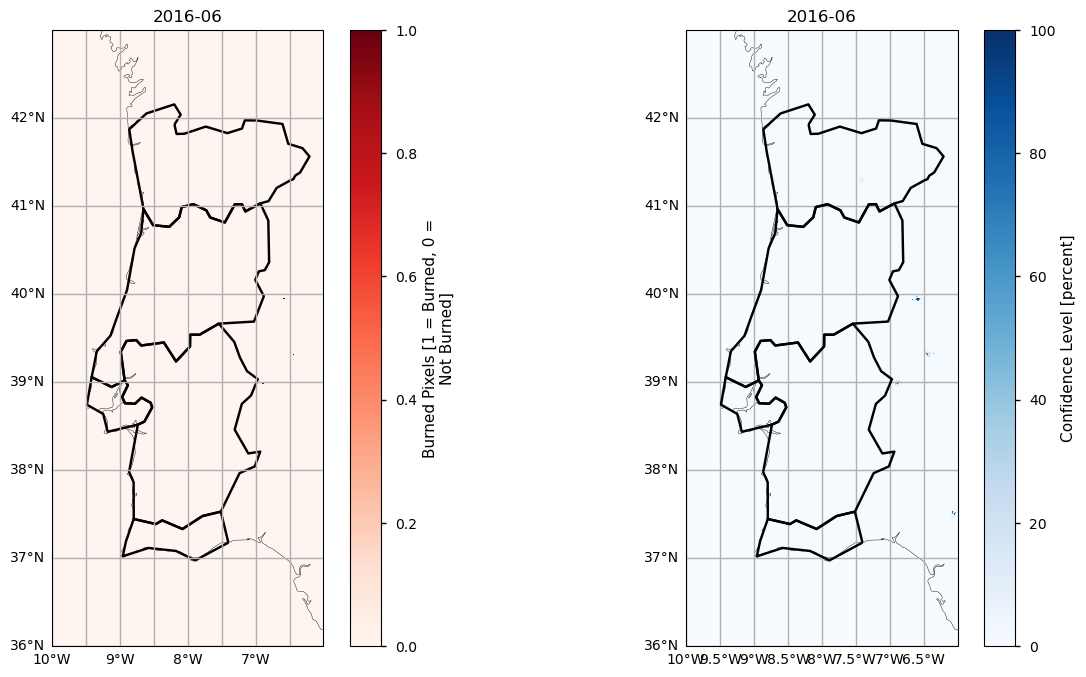

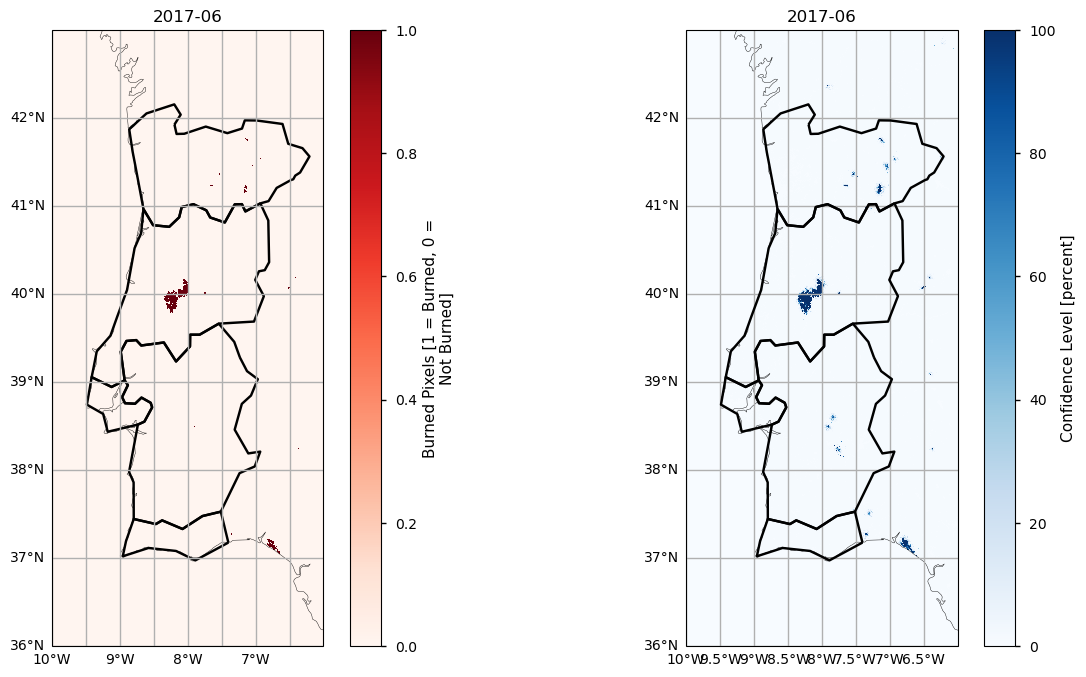

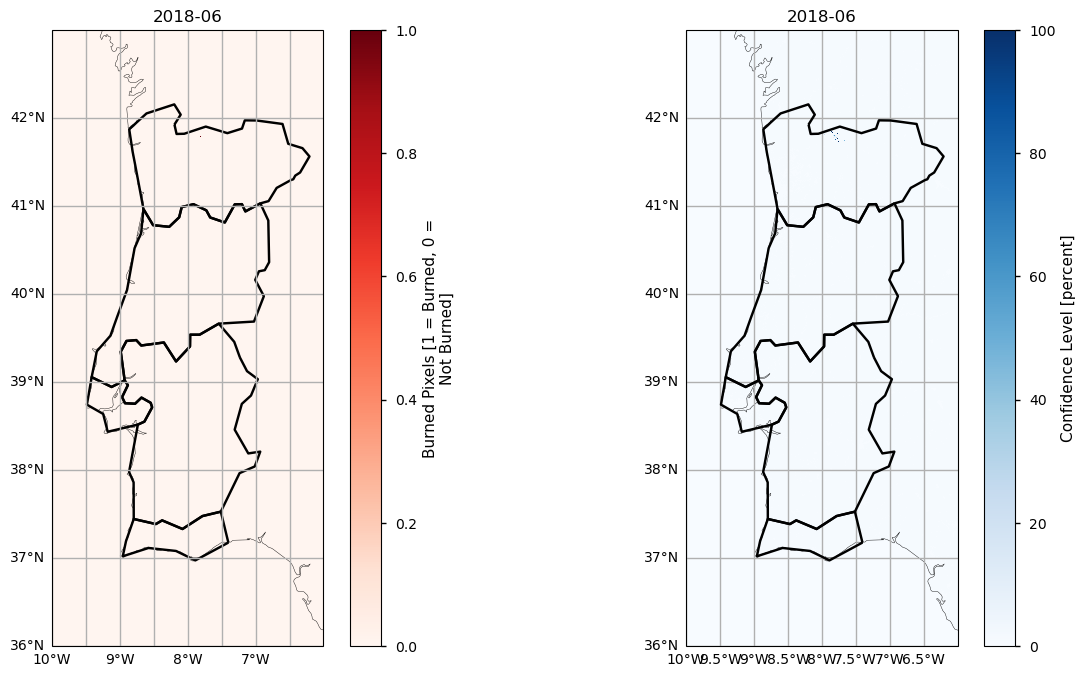

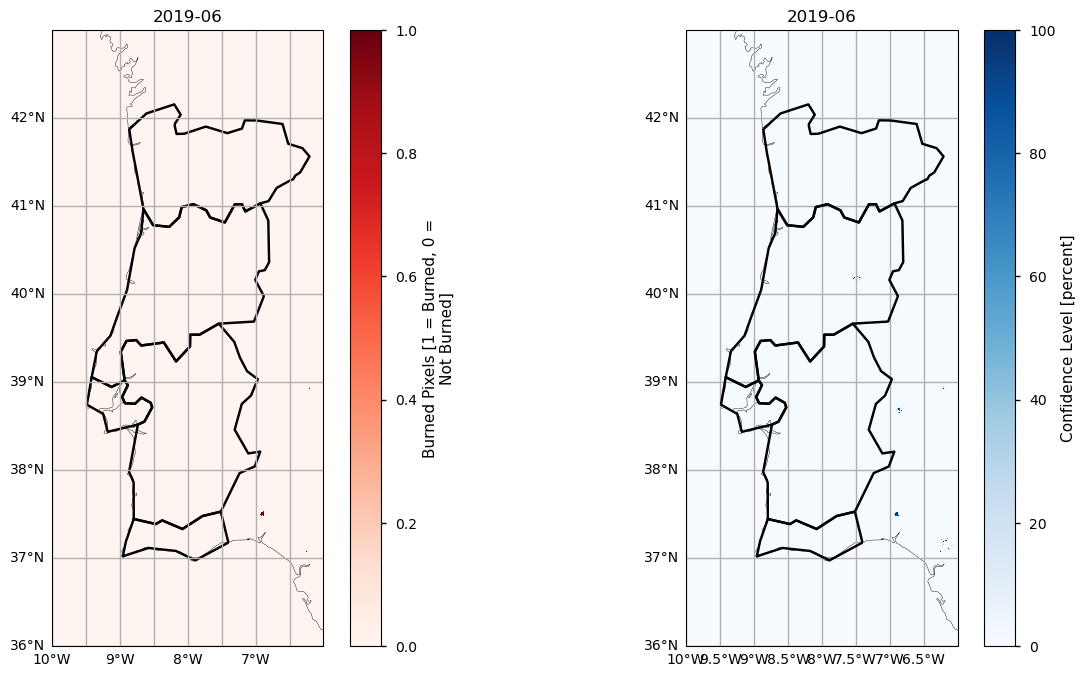

In [9]:
for time, ds_time in ds.groupby("time"):
    ds_time = ds_time.squeeze()
    fig, axs = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(15, 8),
        subplot_kw={"projection": ccrs.PlateCarree()},
    )

    da = ds_time["JD"] > 0
    da.attrs = {"long_name": "Burned Pixels", "units": "1 = Burned, 0 = Not Burned"}
    plot.projected_map(da, ax=axs[0], cmap="Reds", show_stats=False)
    plot.projected_map(ds_time["CL"], ax=axs[1], cmap="Blues", show_stats=False)

    for ax in axs:
        ax.set_title(time)
        gdf.boundary.plot(ax=ax, color="k", transform=ccrs.PlateCarree())
    plt.show()

This maps reprsent the comparation between the total burned area and the confidence level from 2016 to 2019 (only for month of June) and an be observed, acordingly with the pivot table above, for the years 2016, 2018 and 2019, there are no fisible changes and the most affected area were Centro (PT), Norte and Alentejo. Althout for June 2017, Burned areas in all regions are minimal, indicating relatively low fire activity during this period, but  The Centro (PT) region shows a significant increase compared to other regions. This coroborates with the impact that Pedrogão Grande Wildfire reported by several scientific papers (e.g., [[3]](https://www.mdpi.com/2571-6255/7/3/90), [[4]](https://www.mdpi.com/2571-6255/3/4/57), [[5]](https://doi.org/10.1016/j.agrformet.2024.110108)).


(code-section-4)=
### 4. Land Cover Analysis

In this section it will be introduced the analysis of the total area of Land Cover class Forest that was burned  (in this notebook the Land Cover information is retreived from the FIRE dataset).

In this section it will be performed a Bar chart with the total burned area versus Land Cover class Forest per timestamp (in km²)

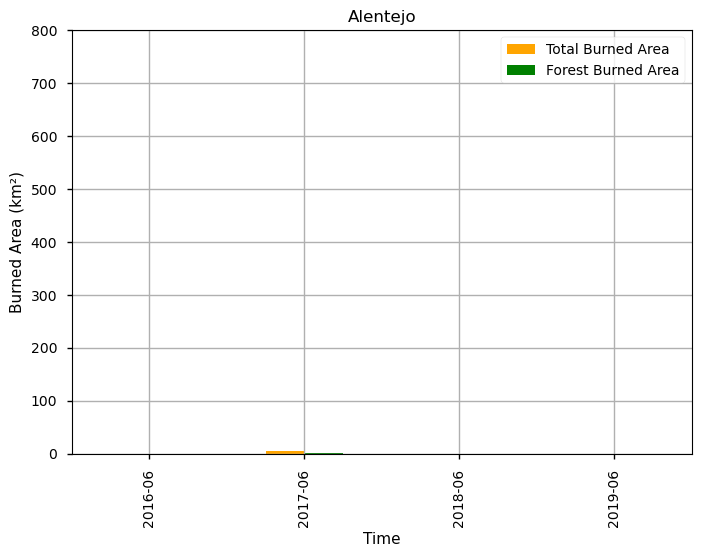

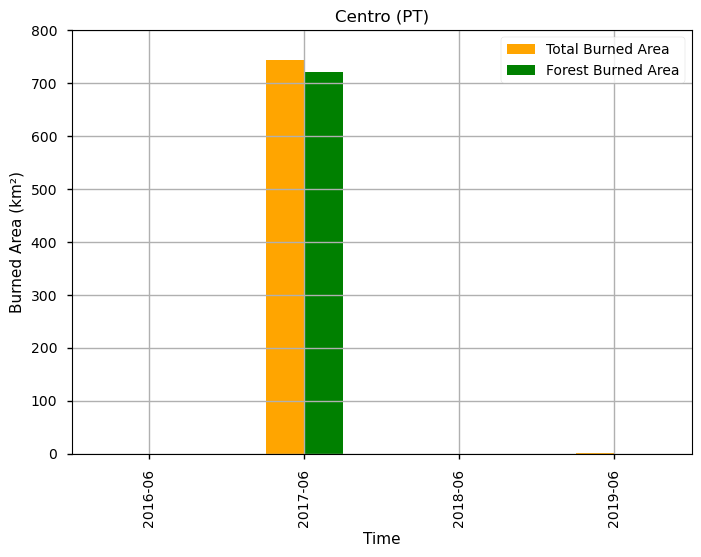

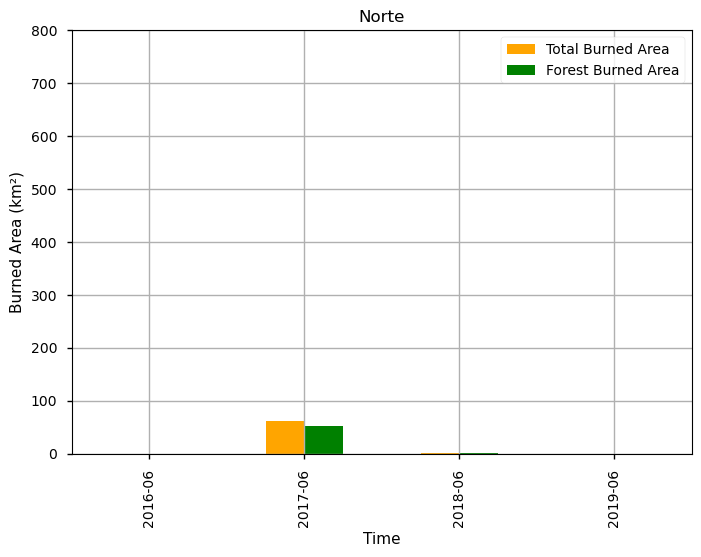

In [10]:
forest_pixels = (
    ds_region["cell_area"]
    .where(ds_region["LC"].isin(forest_codes))
    .sum(["latitude", "longitude"])
)
da = xr.merge(
    [
        burned_pixels.rename("Total Burned Area"),
        forest_pixels.rename("Forest Burned Area"),
    ]
)
df = da.to_dataframe()[["Total Burned Area", "Forest Burned Area"]]

# Filter out regions where the total burned area is 0 for all years
non_zero_regions = df.groupby("region")["Total Burned Area"].sum() > 0
df_filtered = df[df.index.get_level_values("region").isin(non_zero_regions[non_zero_regions].index)]

# Determine y-axis limits
ylim = [0, 100 * (np.ceil(df_filtered.max().max() / 100))]

# Plot bar charts for each region
for region, df_region in df_filtered.reset_index().groupby("region"):
    df_region.plot.bar(
        x="time",
        grid=True,
        ylim=ylim,
        title=region,
        color=["orange", "green"],
        ylabel="Burned Area (km²)",
        xlabel="Time",
    )

In this section, it is represented the Bar chart with the total burned area versus the Land Cover class Forest per timestamp (in km²) for the regions that represented values of brned area.

For Alentejo:
- The burned area is negligible except for a small spike in June 2017.
- The burned area in Alentejo was minimal during the observed period, indicating limited wildfire activity.
- In June 2017 were observed a peak, though small, that can suggest a localized fire event, but overall fire occurrences are not significant in this region during this timeframe.

For Centro (PT):
- A significant peak in June 2017, with the total burned area close to 750 km² in wich the main burned area was forest.
- The lack of significant burned area in 2018 and 2019 suggests improved conditions, fire management, or fewer fire-prone circumstances.


From the analysis, the years 2016, 2018, and 2019 show no significant occurrences of burned forest area across all regions, with minimal or negligible values reported.

However, June 2017 stands out as an exceptional year for forest fires, particularly in the Centro (PT) region, which recorded an overwhelming burned area of nearly 750 km². This accounts for the vast majority of the total burned area in the dataset.

Other regions, such as Norte, reported moderate burned areas during the same period, though significantly lower than in Centro (PT). Meanwhile, regions like Alentejo and Área Metropolitana de Lisboa show negligible or no significant forest fire activity throughout the analyzed period.

This updated analysis reinforces that the forest fires of June 2017 were concentrated primarily in the Centro (PT) region, with Norte experiencing a smaller but notable impact, while other regions were largely unaffected.

(code-section-5)=
### 5. Main Takeaways

* The analysis focuses only on the regions of Centro (PT), Norte, and Alentejo, as other regions with zero burned area values contribute no relevant information to wildfire activity.

* The temporal analysis highlights a significant spike in burned area during June 2017, exceeding 750 km² in the Centro (PT) region, which was primarily forest land cover. This aligns with the catastrophic wildfire in Pedrógão Grande, as reported in scientific literature ([[3]](https://www.mdpi.com/2571-6255/7/3/90), [[4]](https://www.mdpi.com/2571-6255/3/4/57) and [[5]](https://doi.org/10.1016/j.agrformet.2024.110108)).

* The Maps representation confirms that Centro (PT) was the most severely impacted region, with Norte showing moderate burned areas during the same period. Alentejo recorded a small peak in burned area for June 2017, though overall wildfire activity was minimal. Regions like Área Metropolitana de Lisboa exhibited negligible or no wildfire activity throughout the analyzed years.

* Across the years 2016, 2018, and 2019, no significant changes in burned area were observed during June, indicating relatively low fire activity across all regions. This underscores the anomalous nature of June 2017 as an extreme wildfire event.

* The FIRE dataset remains a reliable tool for assessing burned areas and land cover changes. Its pixel-level granularity and confidence level information ensure accurate spatial estimates of wildfire impacts, particularly for extreme events like Pedrógão Grande.

* This analysis emphasizes the importance of high-resolution spatial data in wildfire assessments. Insights gained can support disaster response, fire risk management, and long-term recovery planning, in alignment with the European State of Climate report ([[1]](https://climate.copernicus.eu/esotc/2023)).

* The findings align with IPCC forest group definitions and reinforce the need for continued monitoring using datasets like FIRE ([[2]](https://www.mdpi.com/2073-4433/12/1/85)). Such tools are essential for understanding wildfire dynamics and their impacts on forest ecosystems.


## ℹ️ If you want to know more

### Key resources

Some key resources and further reading were linked throughout this assessment.

The CDS catalogue entry for the data used were:

* Fire burned area from 2001 to present derived from satellite observations:

  https://cds.climate.copernicus.eu/datasets/satellite-fire-burned-area?tab=overview

* Land cover classification gridded maps from 1992 to present derived from satellite observations:
  https://cds.climate.copernicus.eu/datasets/satellite-land-cover?tab=overview 

EEA FIRE Climatology Methodology:
* https://www.eea.europa.eu/publications/europes-changing-climate-hazards-1

FIRE dataset Product User Guide (PUG):
* http://datastore.copernicus-climate.eu/documents/satellite-fire-burned-area/D3.3.14-v1.0_PUGS_CDR_BA-FireCCI_MODIS_v5.1cds_PRODUCTS_v1.0.1.pdf 

LULC dataset Product User Guide - Latest Version (PUG):
* http://dast.data.compute.cci2.ecmwf.int/documents/satellite-land-cover/WP2-FDDP-LC-2021-2022-SENTINEL3-300m-v2.1.1_PUGS_v1.1_final.pdf

Eurostat NUTS (Nomenclature of territorial units for statistics) regions and definition link:
* https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts 

Code library used
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [BOpen](https://www.bopen.eu/)


### References:

[[1]](https://climate.copernicus.eu/esotc/2023) Copernicus Climate Change Service. 2024. European State of the Climate 2023. https://climate.copernicus.eu/esotc/2023. 

[[2]](https://www.mdpi.com/2073-4433/12/1/85) Cavaleiro, R., Russo, A., Sousa, P. M., & Durão, R. (2021). Association between Prevailing Circulation Patterns and Coarse Particles in Portugal. Atmosphere, 12(1), 85. https://doi.org/10.3390/atmos12010085

[[3]](https://www.mdpi.com/2571-6255/7/3/90) Silva, D., Ferreira, T. M., & Rodrigues, H. (2024). Assessing the Accuracy of the Wildland–Urban Interface Index in Portuguese Rural Villages’ Context: A Case Study of the 2017 Pedrógão Grande Wildfire. Fire, 7(3), 90. https://doi.org/10.3390/fire7030090

[[4]](https://www.mdpi.com/2571-6255/3/4/57) Ribeiro, L. M., Rodrigues, A., Lucas, D., & Viegas, D. X. (2020). The Impact on Structures of the Pedrógão Grande Fire Complex in June 2017 (Portugal). Fire, 3(4), 57. https://doi.org/10.3390/fire3040057

[[5]](https://doi.org/10.1016/j.agrformet.2024.110108) Menezes, L. S., Russo, A., Libonati, R., Trigo, R. M., Pereira, J. M., Benali, A., Ramos, A. M., Gouveia, C. M., Morales Rodriguez, C. A., & Deus, R. (2024). Lightning-induced fire regime in Portugal based on satellite-derived and in situ data. Agricultural and Forest Meteorology, 355, 110108. https://doi.org/10.1016/j.agrformet.2024.110108